# SOAP analysis of Si trajectory

This notebook shows how to perform a SOAP analysis of a Si trajectory.

The MD simulation involves the compression of a 10,000 atom structural model of low-density amorphous silicon (a-Si) from 0-20 GPa,  
similar to that described in [J. Chem. Phys. __157__, 104105 (2022)](https://doi.org/10.1063/5.0099929).  

Here, we use a smaller system size (10k vs. 100k) to reduce the computational cost of the analysis  
so that it can be run on a laptop in a few minutes.

We're going to compare the snapshots from the large-scale MD to some known crystal structures of Si   
to understand the structural changes that occur during compression.

In [4]:
# Note you need to be running the notebook from the root directory of the repository
# # `os.chdir('path/to/repo')` will achieve this
from ase.io import read, write
import os
import pandas as pd
import numpy as np
from share.utilities import read_lammps_log
import matplotlib.pyplot as plt
plt.style.use('./share/plot.mplstyle')

unpack our example trajectory

In [176]:
!tar -xzvf structures/Si_10katom_simulation.xyz.tar.gz

structures/Si_10katom_simulation.xyz


In [177]:
Si_traj = read('structures/Si_10katom_simulation.xyz', ':')
print(Si_traj[0])

Atoms(symbols='Si10000', pbc=True, cell=[59.0629, 59.0629, 59.0629], masses=...)


This is the thermodynamic output from LAMMPS, which we'll use to plot the pressure and temperature

Definitions:
* Step      =       timestep (in fs)
* CPU       =       CPU time
* Temp      =       instantaneous temperature at timestep *step*
* f_TempAve =       average temperature over the last 1000 timesteps
* Press     =       instantaneous pressure
* f_PressAve=       average pressure
* f_PEAve_Atom=     average potential energy per atom
* c_MSD[4]  =       mean square displacement of atoms

In [178]:
thermo = read_lammps_log('structures/log_npt_Si_mtp.dat')
thermo.head()

,Step,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
0,0.0,0.000000,500.00000,0.00000,200.47885,0.000000,0.00000,206036.57,0.00,0.000000
2,1000.0,66.406337,499.06923,496.43517,469.56218,-0.746819,-162.92661,205947.39,206035.67,0.099112
3,2000.0,132.756830,504.12737,500.23940,367.79051,-41.270840,-162.92650,205852.77,206019.93,0.104916
4,3000.0,199.107770,498.82079,500.74544,108.73607,-61.930008,-162.92650,206026.93,206014.29,0.102298
5,4000.0,265.756330,499.03487,499.13229,-185.78896,-85.978728,-162.92618,206067.84,206029.74,0.103973


# Create reference crystal structures

In [179]:
from ase.lattice.hexagonal import Hexagonal
from ase.build import bulk
from ase import Atoms

In [181]:
diamond = bulk('Si', 'diamond', a=5.43)
simple_hexagonal = Atoms(Hexagonal(symbol='Si', latticeconstant={'a': 1.7, 'c':2.3}))

print('Diamond structure Atoms object: ', diamond, '\n')

print('Simple hexagonal Atoms object ', simple_hexagonal)

Diamond structure Atoms object:  Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]]) 

Simple hexagonal Atoms object  Atoms(symbols='Si', pbc=True, cell=[[1.7, 0.0, 0.0], [-0.8499999999999995, 1.4722431864335457, 0.0], [0.0, 0.0, 2.3]])


In [182]:
# In case you want to visualise them with Ovito https://www.ovito.org/manual/installation.html
write('structures/Si_diamond.xyz', diamond)
write('structures/Si_simple_hexagonal.xyz', simple_hexagonal)

<font size= "6">Reference structures<font size= "4">  
illustrated

<img src="images/dia_crystal.png" width="300" height="300"/><img src="images/sh_crystal.png" width="300" height="300"/>   

Visualisation using [Ovito](https://www.ovito.org/)

# Optimise geometries of reference structure

We do this for a range of pressures, so that the conditions for the reference crystal  
are comparable to those in the MD simulation.

Here we relax the diamond reference structure with the Silicon GAP potential from [Phys. Rev. X __8__, 041048](https://doi.org/10.1103/PhysRevX.8.041048)

Note that we don't relax simple hexagonal Si with this potential at low pressures -   
the GAP model has not been trained in this region, and doesn't bind the structure strongly enough!

In [5]:
from share.utilities import optimise_structure
from quippy.potential import Potential

Download GAP-18 potential

In [15]:
%%capture download_output

os.makedirs('potentials', exist_ok=True)
!wget https://github.com/libAtoms/silicon-testing-framework/raw/master/models/GAP/gp_iter6_sparse9k.xml -P potentials/
!wget https://github.com/libAtoms/silicon-testing-framework/raw/master/models/GAP/gp_iter6_sparse9k.xml.sparseX.GAP_2017_6_17_60_4_3_56_1651.bz2 -P potentials/
!bunzip2 potentials/gp_iter6_sparse9k.xml.sparseX.GAP_2017_6_17_60_4_3_56_1651.bz2

In [16]:
GAP18 = Potential(param_filename='potentials/gp_iter6_sparse9k.xml')

optimise diamond structure at a sample of pressures

In [185]:
%%capture geometry_optimisation_output 

pressures = thermo['f_PressAve'].values / (1e4*160.2177) # convert kbar to eV/A^3

# pad pressures to ensure we only interpolate, not extrapolate, when fitting
optimisation_pressures = np.concatenate([[-1e-4], pressures[::10], [pressures[-1] + 1e-4]])

# optimise diamond
optimised_diamonds = [optimise_structure(diamond.copy(), GAP18, P=p) for p in optimisation_pressures]


In [68]:
# run this to see the log output from the geometry optimisations (quite long, so omitted here!)
# geometry_optimisation_output.show()

## Fitting of the lattice parameters

by fitting the lattice vectors instead of optimising at each pressure, we can get away with only a few optimisations  
(particularly valuable if you're using DFT to get the equilibrium lattice parameters for the reference crystals)

In [186]:
from scipy.interpolate import interp1d

simple cubic spline interpolation of the lattice

In [187]:
lattices = np.array([i.cell.array for i in optimised_diamonds]).T
lattice_fit = interp1d(optimisation_pressures, lattices, kind='cubic')

plot the lattice parameter as a function of pressure to check the quality of the interpolation

[Text(0.5, 0, 'Pressure (GPa)'),
 Text(0, 0.5, 'Lattice constant ($\\mathrm{\\AA}$)')]

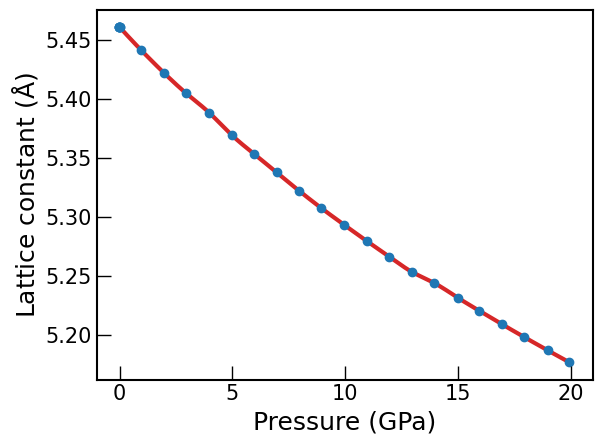

In [188]:
fig, axs = plt.subplots()

lattice_predictions = lattice_fit(pressures)

axs.scatter(optimisation_pressures[1:-1]*160.2177, [at.cell[0,1]*2 for at in optimised_diamonds[1:-1]], color='tab:blue', label='Optimised lattice constant')
axs.plot(pressures*160.2177, lattice_predictions[0,1]*2, color='tab:red', label='Interpolated lattice constant', zorder=0.5)

axs.set(xlabel='Pressure (GPa)', ylabel='Lattice constant ($\mathrm{\AA}$)')

# Set up SOAP descriptor

In [189]:
from quippy.descriptors import Descriptor

In [190]:
soap_descriptor_str = ('soap l_max=3 n_max=6 ' # basis function size
                       'atom_sigma=0.5 cutoff=5.0 ' # smoothness and cutoff (Angstrom) 
                       'average=T') # average descriptor over whole cell, or calculate one descriptor for each atom
                       
soap_cell_average = Descriptor(soap_descriptor_str)
soap_atomistic = Descriptor(soap_descriptor_str.replace('average=T', 'average=F'))

# Create SOAP vectors for each structure

In [191]:
# calculate every 5th structure in the MD trajectory
# to speed things up (this will take up to 5 mins)
average_descriptor = soap_cell_average.calc_descriptor(Si_traj[::5])
atomistic_descriptor = soap_atomistic.calc_descriptor(Si_traj[::5])

# get rid of unnecessary dimensions in arrays produced by calc_descriptor()
average_descriptor = np.array(average_descriptor).squeeze() 
atomistic_descriptor = np.array(atomistic_descriptor).squeeze()

In [194]:
# calculate descriptors for the reference crystals

diamond_descriptor = soap_cell_average.calc_descriptor(diamond).squeeze()
simple_hexagonal_descriptor = soap_cell_average.calc_descriptor(simple_hexagonal).squeeze()

In [195]:
simple_hexagonal_descriptor.shape  # SOAP vector length

(85,)

calculate the SOAP vectors for a diamond structure at the measured pressure of each frame in the MD trajectory

In [196]:
fitted_diamonds = []

for i, val in enumerate(pressures):
    at = diamond.copy()
    at.set_cell(lattice_fit(val), scale_atoms=True)
    fitted_diamonds.append(at.copy())

fitted_diamond_descriptors = np.array([soap_cell_average.calc_descriptor(at) for at in fitted_diamonds]).squeeze()

# Calculate SOAP kernel matrix

We use a SOAP kernel -- here defined as the dot product of the SOAP vectors raised to a power, *zeta*

$$ K_{ij} = (k_i \cdot k_{j})^{\zeta} $$

In [197]:
zeta = 4  # exponent for the kernel

# calculate dot products
k_dia_av = np.dot(average_descriptor, diamond_descriptor)**zeta # cell-averaged kernel
k_dia_atomistic = np.dot(atomistic_descriptor, diamond_descriptor)**zeta # atomistic kernel

# pressure-adjusted, cell-averaged kernel
k_dia_pressure_adjusted_av = [np.dot(i,j)**zeta for (i,j) in zip(average_descriptor, 
                                                                fitted_diamond_descriptors[::5])]


In [199]:
k_simple_hexagonal_av = np.dot(average_descriptor, simple_hexagonal_descriptor)**zeta
k_simple_hexagonal_atomistic = np.dot(atomistic_descriptor, simple_hexagonal_descriptor)**zeta

# Pressure vs. similarity plot

Notice that the pressure-adjusted curve is slightly higher and flatter than the unadjusted curve.
This is because the diamond crystal is shrinking under pressure, reducing the effect of uninteresting changes of density
on the SOAP similarity, increasing the contrast for interesting structural changes. The effect is more pronounced for
larger systems.

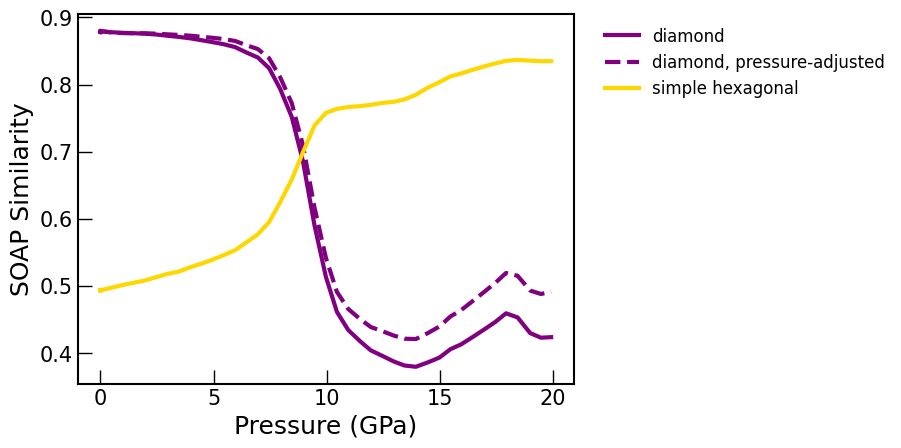

In [200]:
fig, axs = plt.subplots()


pressure_Gpa = thermo['f_PressAve'][::5]/1e4 # convert from LAMMPS kbar to GPa

# plot Diamond similarity
axs.plot(pressure_Gpa, k_dia_av, label='diamond', c='purple')
axs.plot(pressure_Gpa, k_dia_pressure_adjusted_av, label='diamond, pressure-adjusted', c='purple', ls='--')

# plot simple hexagonal similarity
axs.plot(pressure_Gpa, k_simple_hexagonal_av, label='simple hexagonal', c='gold')

axs.set(xlabel='Pressure (GPa)', ylabel='SOAP Similarity')
axs.legend(loc='upper left', bbox_to_anchor=(1, 1.05), frameon=False)

# Label each atom with similarity
to reference structures for visualisation in Ovito

In [201]:
# one kernel value for each atom in each frame of the trajectory
k_dia_atomistic.shape

(51, 10000)

In [206]:
len(Si_traj[::5])

51

In [215]:
# save our SOAP kernel data to each frame in the trajectory
for ct, i in enumerate(range(0,len(Si_traj),5)):
    Si_traj[i].arrays['k_dia'] = k_dia_atomistic[ct, :]
    Si_traj[i].arrays['k_simple_hexagonal'] = k_simple_hexagonal_atomistic[ct, :]

In [216]:
Si_traj[0].arrays['k_dia'][:10] # this is the array of SOAP similarity values from 0-1

array([0.93634892, 0.72644373, 0.85782427, 0.80764712, 0.94831613,
       0.87921961, 0.81887103, 0.97075541, 0.79048884, 0.95895056])

In [217]:
write('structures/Si_traj_SOAPlabelled.xyz', Si_traj[::5])

<img src="images/dia.png" width="300" height="300" /><img src="images/10GPa.png" width="300" height="300" /><img src="images/sh.png" width="300" height="300" />


Visualisation using [Ovito](https://www.ovito.org/), with view angle set to illustrate the simple hexagonal *c*-axis.  
Color-coding using the data in the `k_simple_hexagonal` array of the .xyz file.  
  
In Ovito, this amounts to using a *Color coding* modifier, with *Input property* set to `k_simple_hexagonal` and *Color gradient* set to `Viridis`.  